# Capstone Project- EDA Workbook
Cary Mosley, May 2020

## Import Libraries

In [2]:
import pandas as pd
import calendar, time
import datetime as dt
from datetime import date
from pandas.tseries.offsets import DateOffset
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from textblob import TextBlob
import string, re 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



import warnings
warnings.filterwarnings("once")



# EDA
## Stock Data

In [3]:
spy_df=pd.read_pickle('Data/spy_df')
vix_df=pd.read_pickle('Data/vix_df')
qqq_df=pd.read_pickle('Data/qqq_df')
iwm_df=pd.read_pickle('Data/iwm_df')

In [4]:
spy_df

,Adj Close,Ticker
Date,,
2006-06-29,96.124527,SPY
2006-07-06,96.086758,SPY
2006-07-13,94.830073,SPY
2006-07-20,93.916246,SPY
2006-07-27,95.820935,SPY
...,...,...
2020-04-02,253.113998,SPY
2020-04-09,270.555000,SPY
2020-04-16,280.590009,SPY


/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


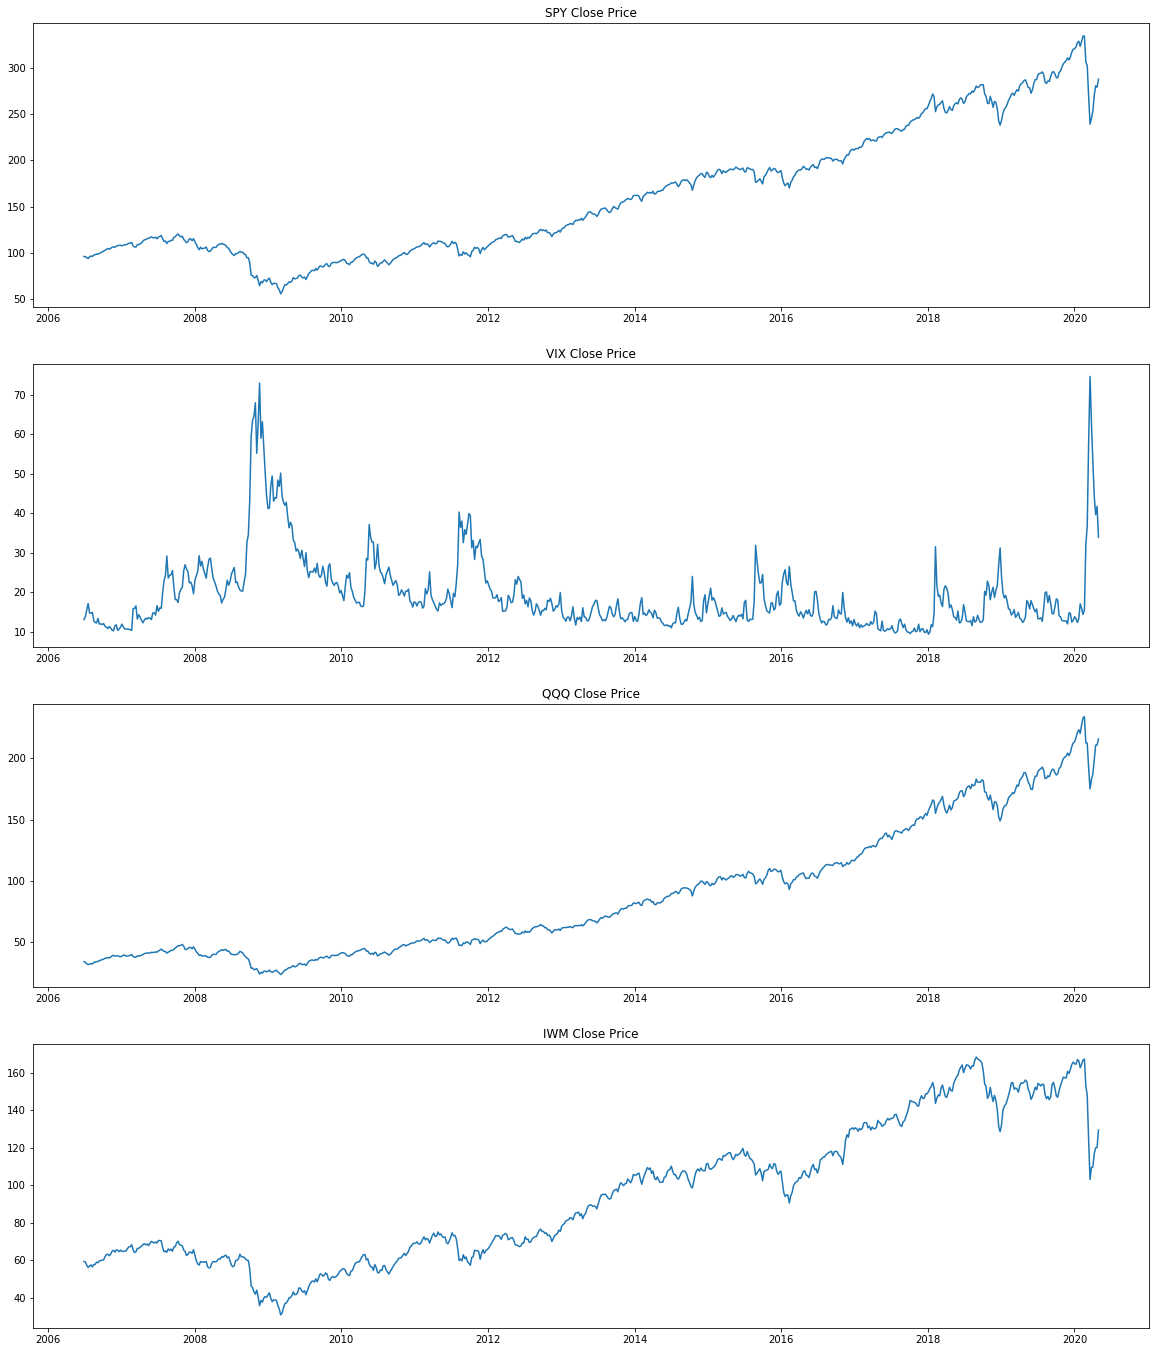

In [5]:
# graphing the closing prices for our Stock Data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(20,24))

ax1.plot(spy_df.index,spy_df['Adj Close'])
ax1.set_title('SPY Close Price')

ax2.plot(vix_df.index,vix_df['Adj Close'])
ax2.set_title('VIX Close Price')

ax3.plot(qqq_df.index,qqq_df['Adj Close'])
ax3.set_title('QQQ Close Price')

ax4.plot(iwm_df.index,iwm_df['Adj Close'])
ax4.set_title('IWM Close Price')


plt.show()




There has been a strong upward trend in the SP500 over the time period shown here with a couple dips at times.

The VIX index doesn't appear to have a strong trend although there are definite moments where it spikes before mean reverting. 

The NASDAQ index has had a steady upward trend over the time period shown

The Russell 2000 index has had a steady upward trend over the time period shown

Now I'll plot the 3 indices on the same plot

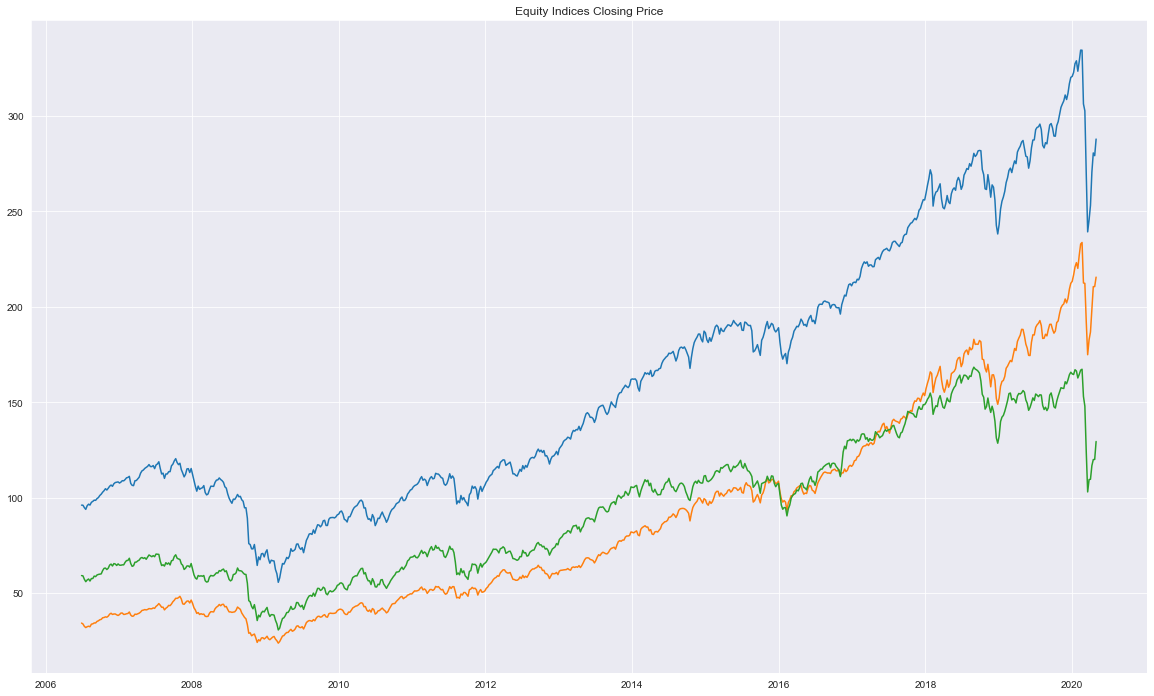

In [163]:
# graphing the closing prices for our Stock Data
fig, ax1 = plt.subplots(1,figsize=(20,12))

ax1.plot(spy_df.index,spy_df['Adj Close'])
ax1.plot(qqq_df.index,qqq_df['Adj Close'])
ax1.plot(iwm_df.index,iwm_df['Adj Close'])
ax1.set_title('Equity Indices Closing Price')


plt.show()




They track each other extremely closely. Due to this, for my initial modeling I will look only at SPY and VIX.

## Sentiment Indicator 

In [62]:
#Read in the pickle dataframe
sentiment_df=pd.read_pickle('Data/sentiment_df')

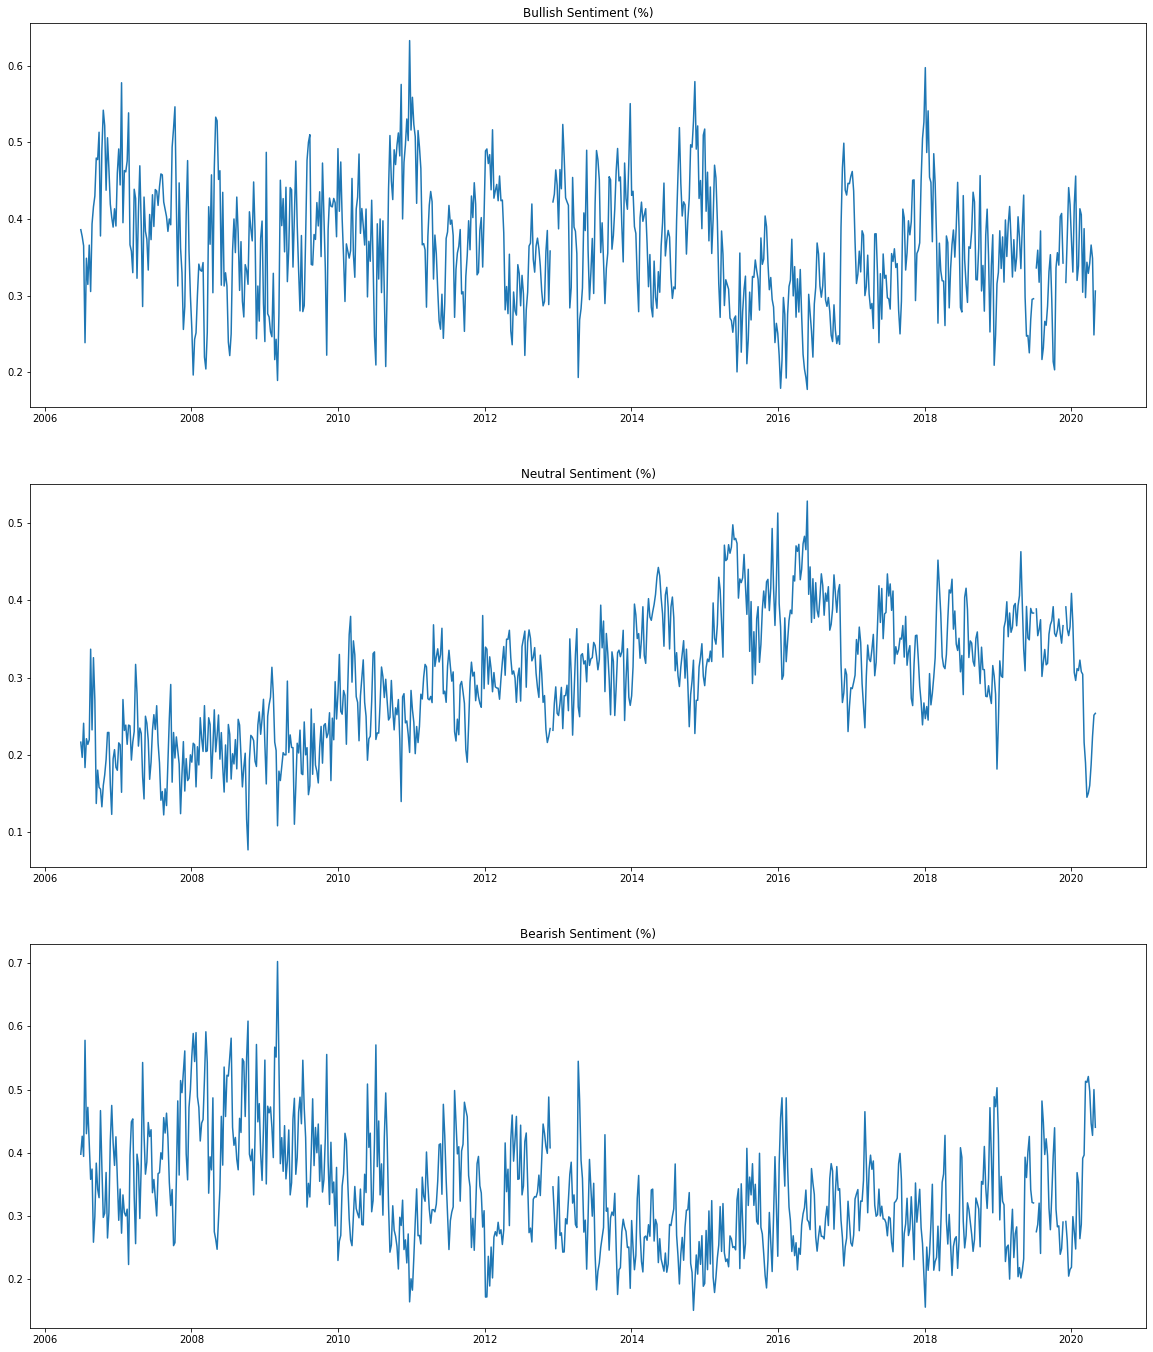

In [21]:
#Time series plots
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(20,24))

ax1.plot(sentiment_df.index, sentiment_df['Bullish'])
ax1.set_title("Bullish Sentiment (%)")

ax2.plot(sentiment_df.index, sentiment_df['Neutral'])
ax2.set_title("Neutral Sentiment (%)")

ax3.plot(sentiment_df.index, sentiment_df['Bearish'])
ax3.set_title("Bearish Sentiment (%)")

plt.show()

Although there is a lot of oscillation there doesnt appear to be any strong trends in the data. Since all three sum to 100% I won't use the neutral sentiment value going forward.

In [22]:
sentiment_df.drop(columns=['Neutral'],inplace=True)

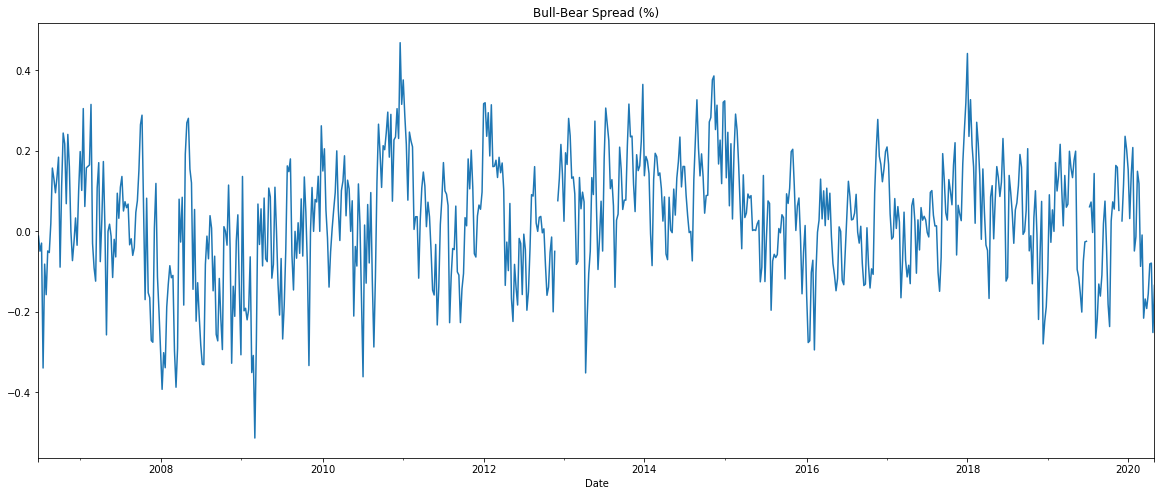

In [23]:
#Time series plots
sentiment_df['Spread'].plot(figsize=(20,8))
plt.title("Bull-Bear Spread (%)")
plt.show()

There also doesn't seem to be a strong trend in the spread between the bullish and bearish sentiment. I'm hopefull that the oscillation will provide some value in predicting the mean reversion of VIX or the direction of the equity indices.

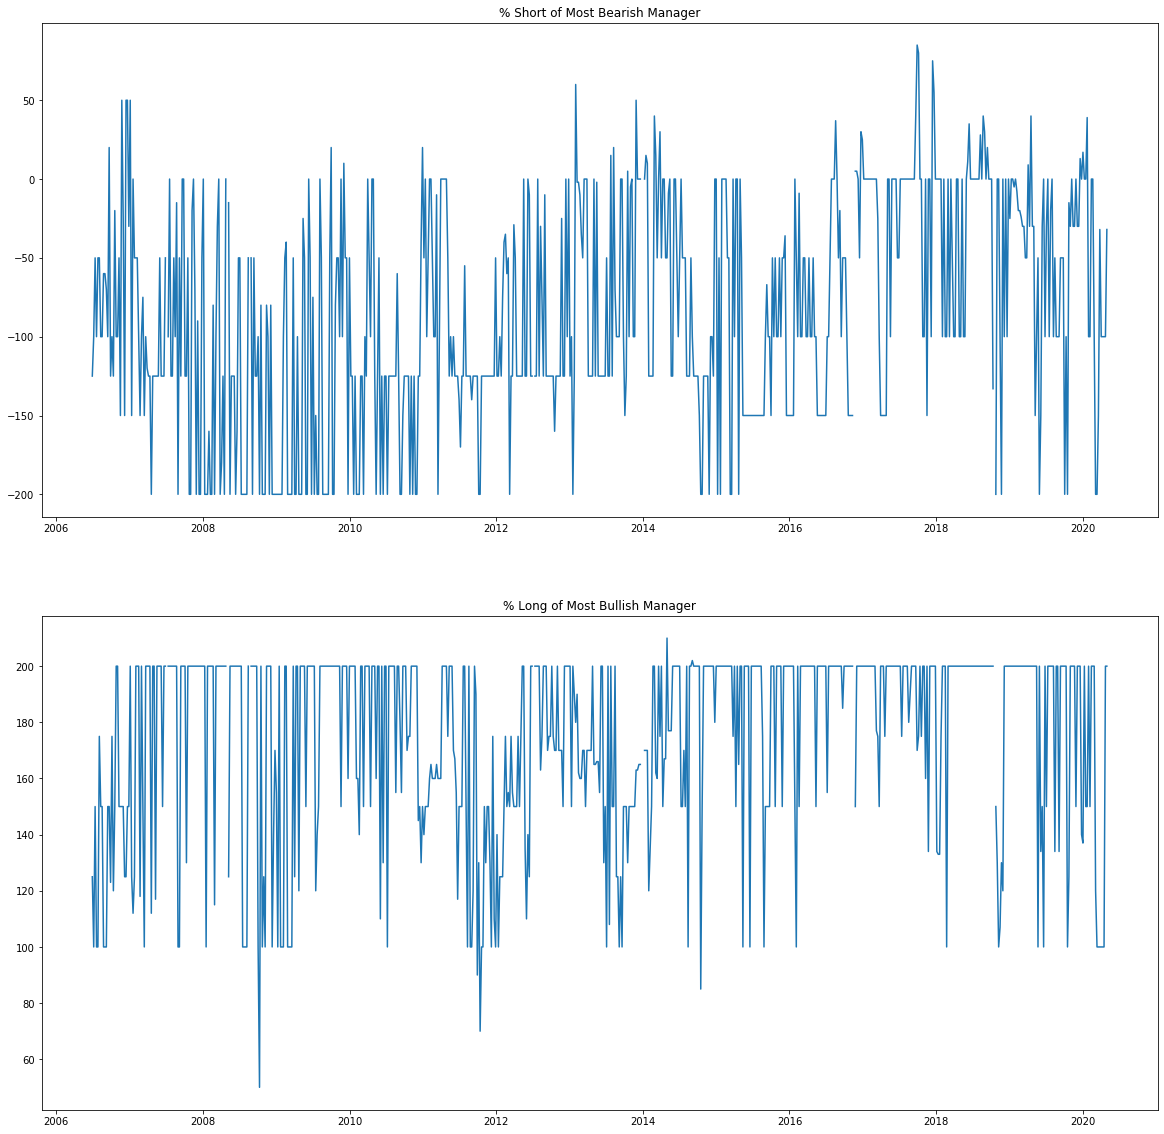

In [41]:
#Time series plots
fig, (ax1, ax2) = plt.subplots(2,figsize=(20,20))

ax1.plot(sentiment_df.index, sentiment_df['MaxBear'])
ax1.set_title("% Short of Most Bearish Manager")

ax2.plot(sentiment_df.index, sentiment_df['MaxBull'])
ax2.set_title("% Long of Most Bullish Manager")

plt.show()

We can see that at times the most short manager still maintains a positive delta exposure to the market! The least long the most bullish manager gets appears to be below 100 only infrequently. It also rarely gets above 200%.

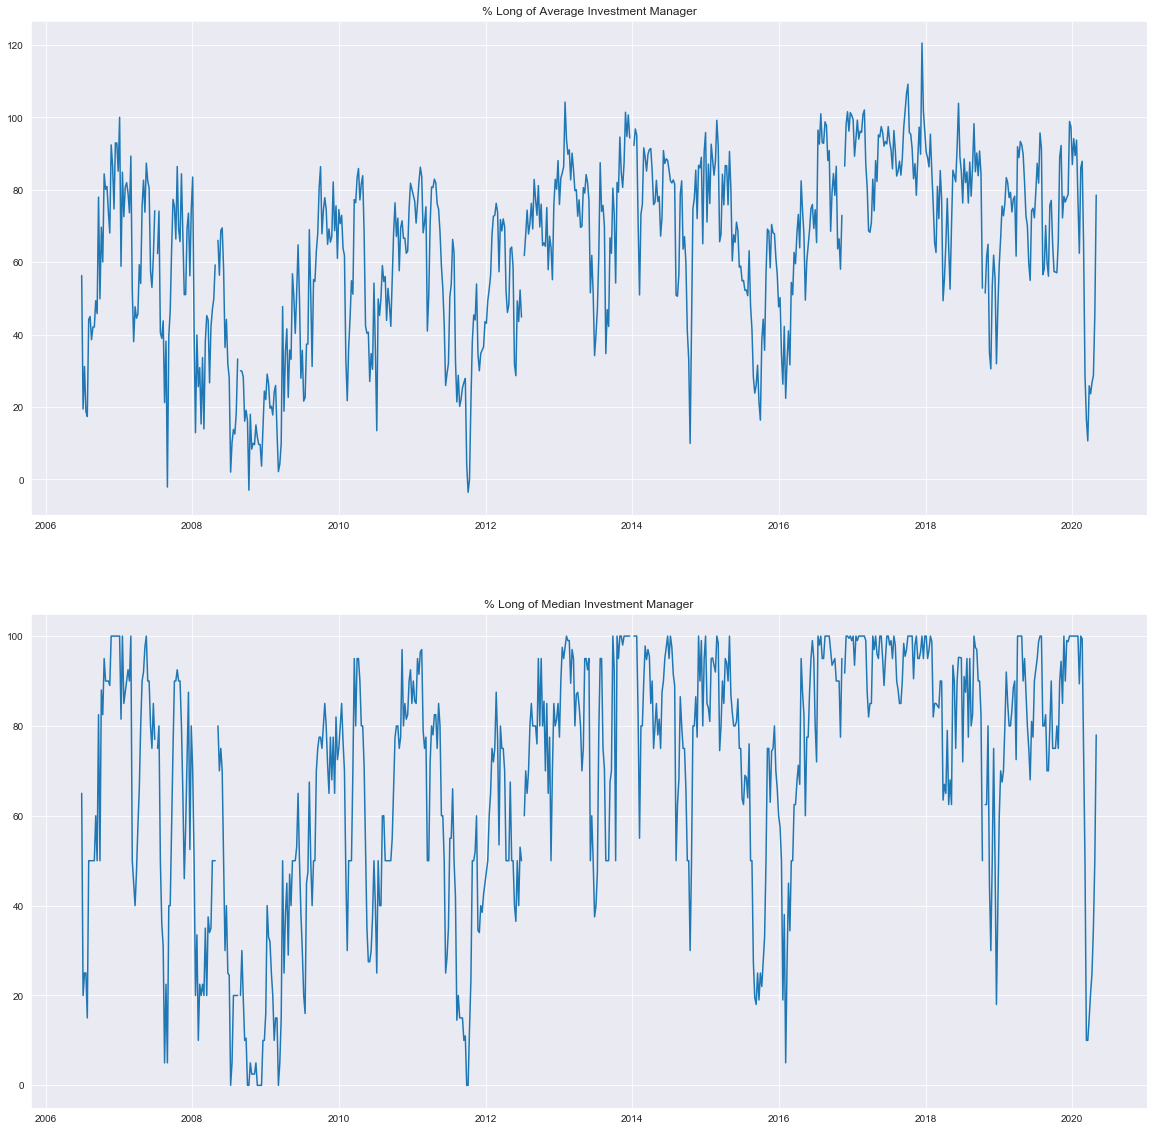

In [49]:
#Time series plots
fig, (ax1, ax2) = plt.subplots(2,figsize=(20,20))

ax1.plot(sentiment_df.index, sentiment_df['Mean'])
ax1.set_title("% Long of Average Investment Manager")

ax2.plot(sentiment_df.index, sentiment_df['Median'])
ax2.set_title("% Long of Median Investment Manager")

plt.show()

Its clear that the mean and median %long oscillates over time without any clear trend with the mean appearing to be somewhat lower than the median.

Now I'll look at the distribution of this data.

In [63]:
print('Sentiment Data Exploration')
print(sentiment_df.describe().transpose())

Sentiment Data Exploration
         count        mean        std         min         25%         50%  \
Bullish  723.0    0.365425   0.079541    0.177515    0.306431    0.363636   
Neutral  723.0    0.298524   0.080035    0.076900    0.237250    0.301486   
Bearish  723.0    0.336051   0.089838    0.150538    0.268583    0.320548   
Spread   723.0    0.029373   0.149629   -0.513500   -0.068150    0.038700   
Mean     723.0   64.008188  24.027561   -3.560000   48.170000   68.700000   
MaxBear  723.0  -84.161826  70.757301 -200.000000 -125.000000 -100.000000   
Median   723.0   69.167815  27.376842    0.000000   50.000000   77.500000   
MaxBull  723.0  175.923928  33.793220   50.000000  150.000000  200.000000   

                75%       max  
Bullish    0.420750    0.6328  
Neutral    0.354340    0.5286  
Bearish    0.393998    0.7027  
Spread     0.133702    0.4688  
Mean      82.650000  120.5600  
MaxBear   -5.000000   85.0000  
Median    92.000000  100.0000  
MaxBull  200.000000  21

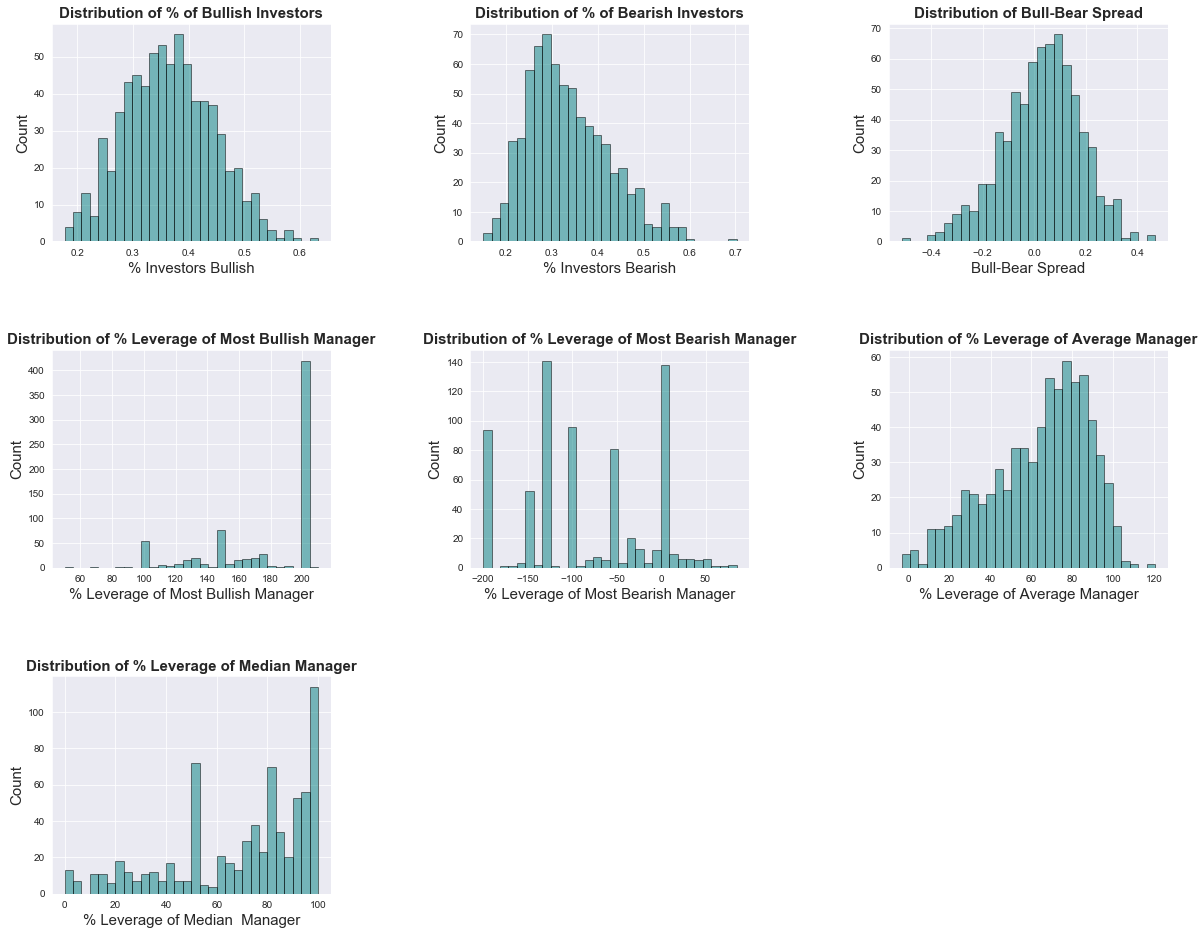

In [55]:
# Plots of the distribution of the sentiment data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .5, wspace = 0.5)

ax1 = fig.add_subplot(331)
ax1.hist(sentiment_df['Bullish'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('% Investors Bullish', fontsize = 15)
ax1.set_ylabel('Count',fontsize = 15)
ax1.set_title('Distribution of % of Bullish Investors',fontsize = 15,fontweight='bold')

ax2 = fig.add_subplot(332)
ax2.hist(sentiment_df['Bearish'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set_xlabel('% Investors Bearish', fontsize = 15)
ax2.set_ylabel('Count',fontsize = 15)
ax2.set_title('Distribution of % of Bearish Investors',fontsize = 15,fontweight='bold')

ax3 = fig.add_subplot(333)
ax3.hist(sentiment_df['Spread'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set_xlabel('Bull-Bear Spread', fontsize = 15)
ax3.set_ylabel('Count',fontsize = 15)
ax3.set_title('Distribution of Bull-Bear Spread',fontsize = 15,fontweight='bold')

ax4 = fig.add_subplot(334)
ax4.hist(sentiment_df['MaxBull'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax4.set_xlabel('% Leverage of Most Bullish Manager', fontsize = 15)
ax4.set_ylabel('Count',fontsize = 15)
ax4.set_title('Distribution of % Leverage of Most Bullish Manager',fontsize = 15,fontweight='bold')

ax5 = fig.add_subplot(335)
ax5.hist(sentiment_df['MaxBear'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax5.set_xlabel('% Leverage of Most Bearish Manager', fontsize = 15)
ax5.set_ylabel('Count',fontsize = 15)
ax5.set_title('Distribution of % Leverage of Most Bearish Manager',fontsize = 15,fontweight='bold')

ax6 = fig.add_subplot(336)
ax6.hist(sentiment_df['Mean'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax6.set_xlabel('% Leverage of Average Manager', fontsize = 15)
ax6.set_ylabel('Count',fontsize = 15)
ax6.set_title('Distribution of % Leverage of Average Manager',fontsize = 15,fontweight='bold')

ax7 = fig.add_subplot(337)
ax7.hist(sentiment_df['Median'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax7.set_xlabel('% Leverage of Median  Manager', fontsize = 15)
ax7.set_ylabel('Count',fontsize = 15)
ax7.set_title('Distribution of % Leverage of Median Manager',fontsize = 15,fontweight='bold')

plt.show()

Observations: 
* The % of investors that are Bullish looks pretty normal distributed centered around 30-40%.

* The % of investors that are beatish is skewed a bit lower but not too tailed. We can see that there are times where investors have been significantly more bearish than bullish.

* The spread between the two is roughly normal centered around positive 10% in the spread.

* The vast majority of the time the most bullish manager holds 200% leverage. It is rare that they are less than this. I might transform this into a dummy feature with 1 when the most bullish is 200% and 0 otherwise.

* The most bearish manager tends to be clustered at 0% long, -50%, -100%, -125%, -150% and -200%.

* The % leverage of the average manager is roughly normal with a  bit of a left tail and looks to be centered around 80%

* The distribution of the median manager is quite different with clusters at 50%, 80% and 100% and a clear left tail in times of market turmoil.




In [68]:
sentiment_df.to_pickle('Data/sentiment_df')

## NYT Article EDA

In [123]:
nyt_df=pd.read_pickle('Data/nyt_df')

In [90]:
nyt_df

,Headline,Snippet
Date,,
2006-06-30,aventine may late,share aventine renewable energy hold large eth...
2006-06-30,ethanol outfit offer,plant nutrient ethanol concern andersons file ...
2006-06-30,london exchange welcome bollywood player,tuesday next week eros international well know...
2006-06-30,house assail media report track,largely party line vote lawmakers call news me...
2006-06-30,world brief europe russia convertible status n...,russian ruble move step closer become fully co...
...,...,...
2020-04-02,slum epicenter duterte drug crackdown fear lov...,height president rodrigo duterte anti crime ca...
2020-04-21,mortgage firm get reprieve pay investors,federal house agency say mortgage servicers mu...
2020-04-21,liu ouqing civil servant help fee wuhan die,china open centrally plan economy liu party se...


In [91]:
nyt_df.groupby(nyt_df.index).count()['Headline']

Date
2006-06-30    11
2006-07-01     5
2006-07-02     5
2006-07-03     6
2006-07-04     6
              ..
2020-04-26     3
2020-04-27     4
2020-04-28     2
2020-04-29     3
2020-04-30     6
Name: Headline, Length: 4836, dtype: int64

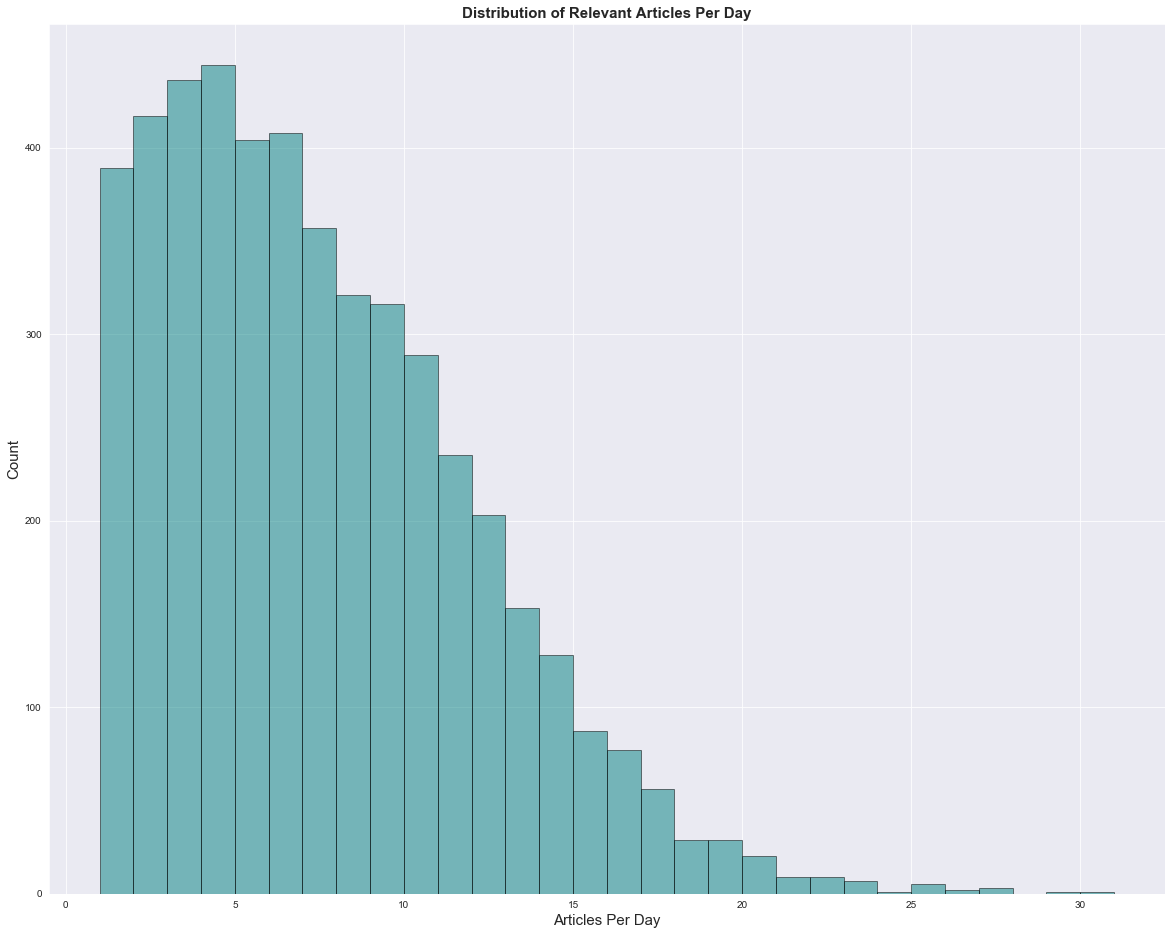

In [92]:
# Plots of the frequency of the articles data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .5, wspace = 0.5)

ax1 = fig.add_subplot(111)
ax1.hist(nyt_df.groupby(nyt_df.index).count()['Headline'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Articles Per Day', fontsize = 15)
ax1.set_ylabel('Count',fontsize = 15)
ax1.set_title('Distribution of Relevant Articles Per Day',fontsize = 15,fontweight='bold')

plt.show()

There is a clear tail in relevant articles per day. My first guess would be that there are more articles when the market is experiencing an adverse event so I plan to explore this more once I have the sentiment analysis finished.

In [101]:

def wordcloud(text,colormap='Blues',interpolation = 'bilinear'):
    '''
    This function takes in text and outputs a wordcloud. Option
    arguments are colormap and interpolation.
    
    Parameters:
        Text - string for visualization
        Colormap - wordcloud theme
        Interpollation - technique
        
    Return:
        Return wordcloud visualization
    '''
    wordcloud = WordCloud(width=1040, height=720, colormap=colormap).generate(text)
    plt.figure(figsize=(20,12))
    plt.imshow(wordcloud, interpolation=interpolation)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

In [94]:
headlines = " ".join(word for word in nyt_df['Headline'])
snippets = " ".join(word for word in nyt_df['Snippet'])


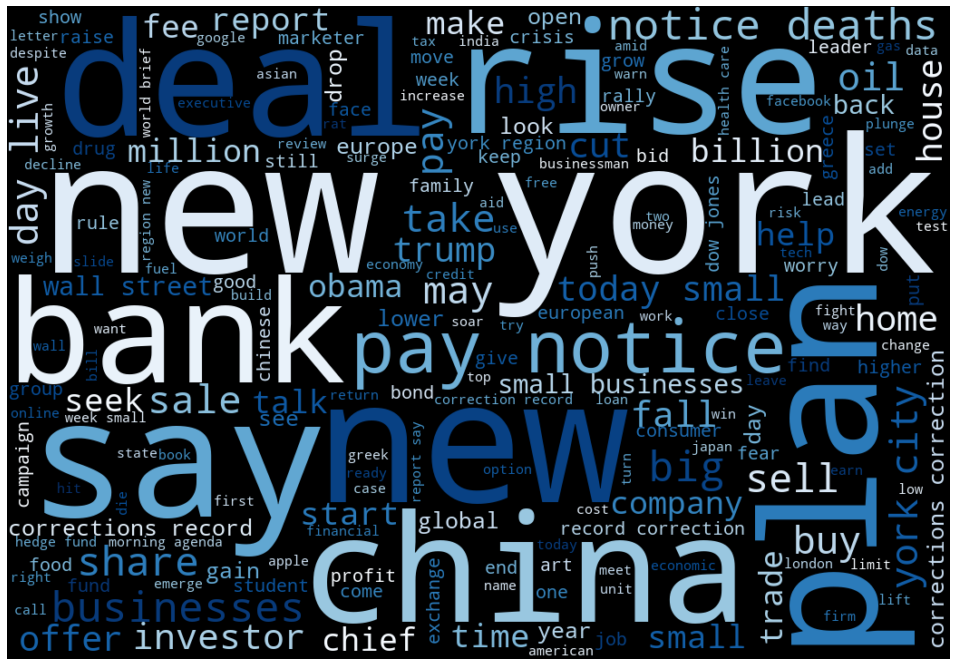

In [102]:
wordcloud(headlines)

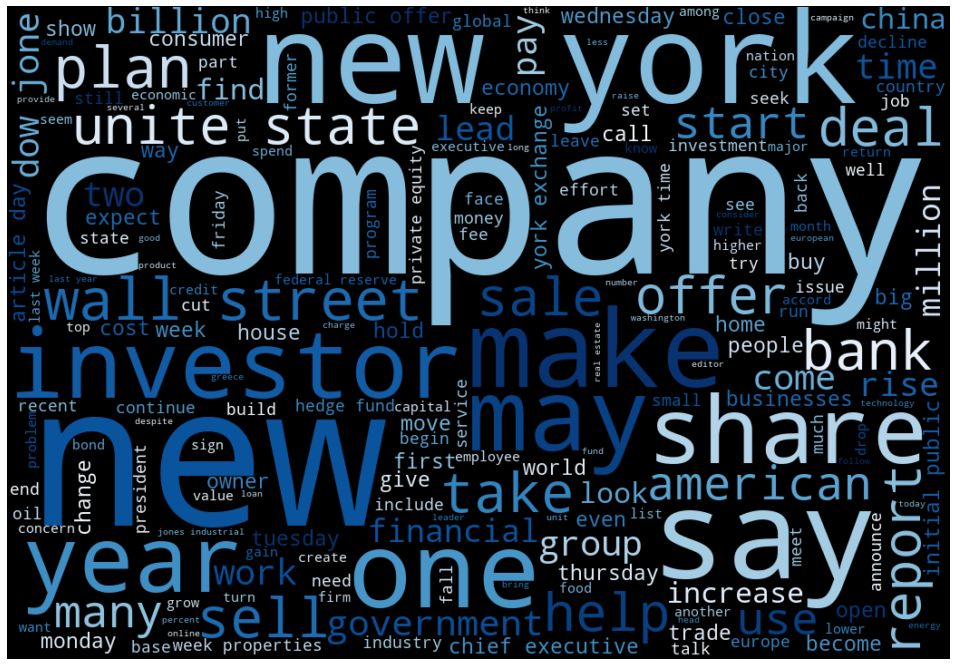

In [103]:
wordcloud(snippets)

The word clouds of the headlines look somewhat similar with New York prominent in both, company very prominent in the snippet cloud. "Deal", "rise", "new", "sell", "investor" are some other common words. 

Next I will use TextBlob and VADER to create some sentiment metrics and explore those!

# NY Times Sentiment Analysis

## Create Sentiment
I'll first use the text blob libary to analyze the sentiment of the headlines and snippets. Since these are news sources I won't use the subjectivity element and will just grab the polarity. The polarity ranges from -1 to 1, negative to positive sentiment.

### Text Blob

In [124]:
#Create TextBlob Sentiment Columns


nyt_df['Headline_Blob'] = nyt_df['Headline'].apply(lambda x: TextBlob(x).sentiment[0])
nyt_df['Snippet_Blob'] = nyt_df['Snippet'].apply(lambda x: TextBlob(x).sentiment[0])

In [125]:
nyt_df['Headline_Blob']

Date
2006-06-30   -0.30
2006-06-30    0.00
2006-06-30    0.80
2006-06-30    0.00
2006-06-30    0.05
              ... 
2020-04-02    0.50
2020-04-21   -0.20
2020-04-21    0.00
2020-04-20    0.00
2020-04-22    0.00
Name: Headline_Blob, Length: 34230, dtype: float64

In [126]:
nyt_df['Snippet_Blob']

Date
2006-06-30    0.232143
2006-06-30   -0.028571
2006-06-30    0.000000
2006-06-30   -0.092857
2006-06-30    0.000000
                ...   
2020-04-02    0.500000
2020-04-21    0.000000
2020-04-21    0.000000
2020-04-20    0.400000
2020-04-22   -0.100000
Name: Snippet_Blob, Length: 34230, dtype: float64

Now lets explore these some!

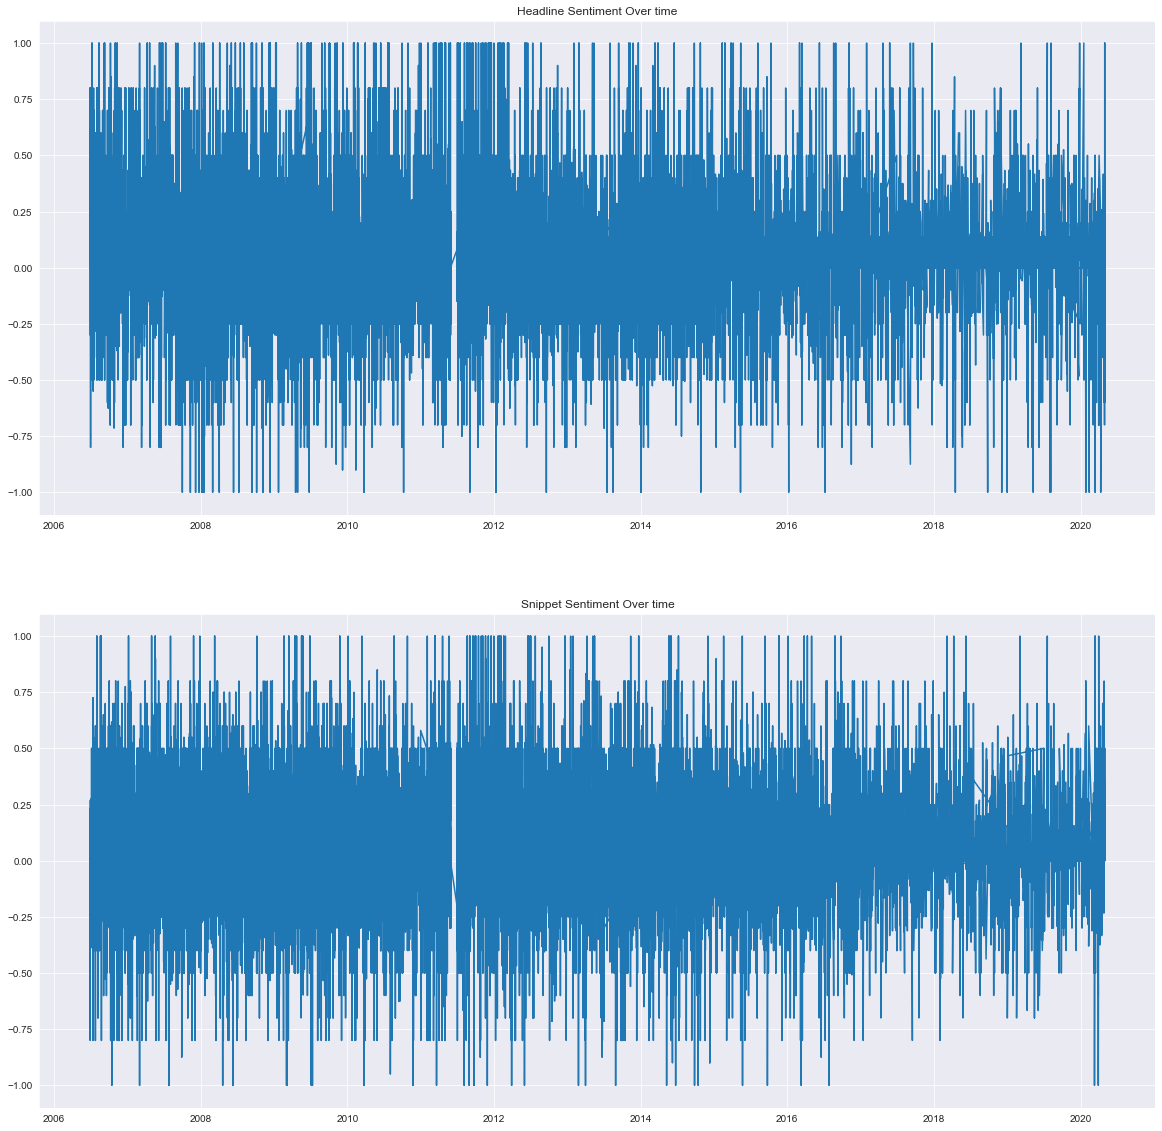

In [127]:
#Time series plots of TextBlob Sentiment
fig, (ax1, ax2) = plt.subplots(2,figsize=(20,20))

ax1.plot(nyt_df.index, nyt_df['Headline_Blob'])
ax1.set_title("Headline Sentiment Over time")

ax2.plot(nyt_df.index, nyt_df['Snippet_Blob'])
ax2.set_title("Snippet Sentiment Over time")

plt.show()

These are extremely noise. Later I will group everything by week, similar to the stock and indicator data and examine these time series again

### VADER Sentiment

In [129]:
#VADER Sentiment
#Initializing analyzer
analyzer = SentimentIntensityAnalyzer()

#Creating columns for VADER Sentiment
nyt_df['Headline_VADER'] = nyt_df['Headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
nyt_df['Snippet_VADER'] = nyt_df['Snippet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [130]:
nyt_df['Headline_VADER']

Date
2006-06-30    0.0000
2006-06-30    0.0000
2006-06-30    0.4588
2006-06-30    0.0000
2006-06-30    0.0000
               ...  
2020-04-02    0.2500
2020-04-21   -0.1027
2020-04-21   -0.2960
2020-04-20   -0.5994
2020-04-22   -0.3612
Name: Headline_VADER, Length: 34230, dtype: float64

In [131]:
nyt_df['Snippet_VADER']

Date
2006-06-30    0.7783
2006-06-30    0.7717
2006-06-30    0.6597
2006-06-30    0.4019
2006-06-30    0.0000
               ...  
2020-04-02   -0.8885
2020-04-21    0.0000
2020-04-21    0.6597
2020-04-20    0.0000
2020-04-22    0.0000
Name: Snippet_VADER, Length: 34230, dtype: float64

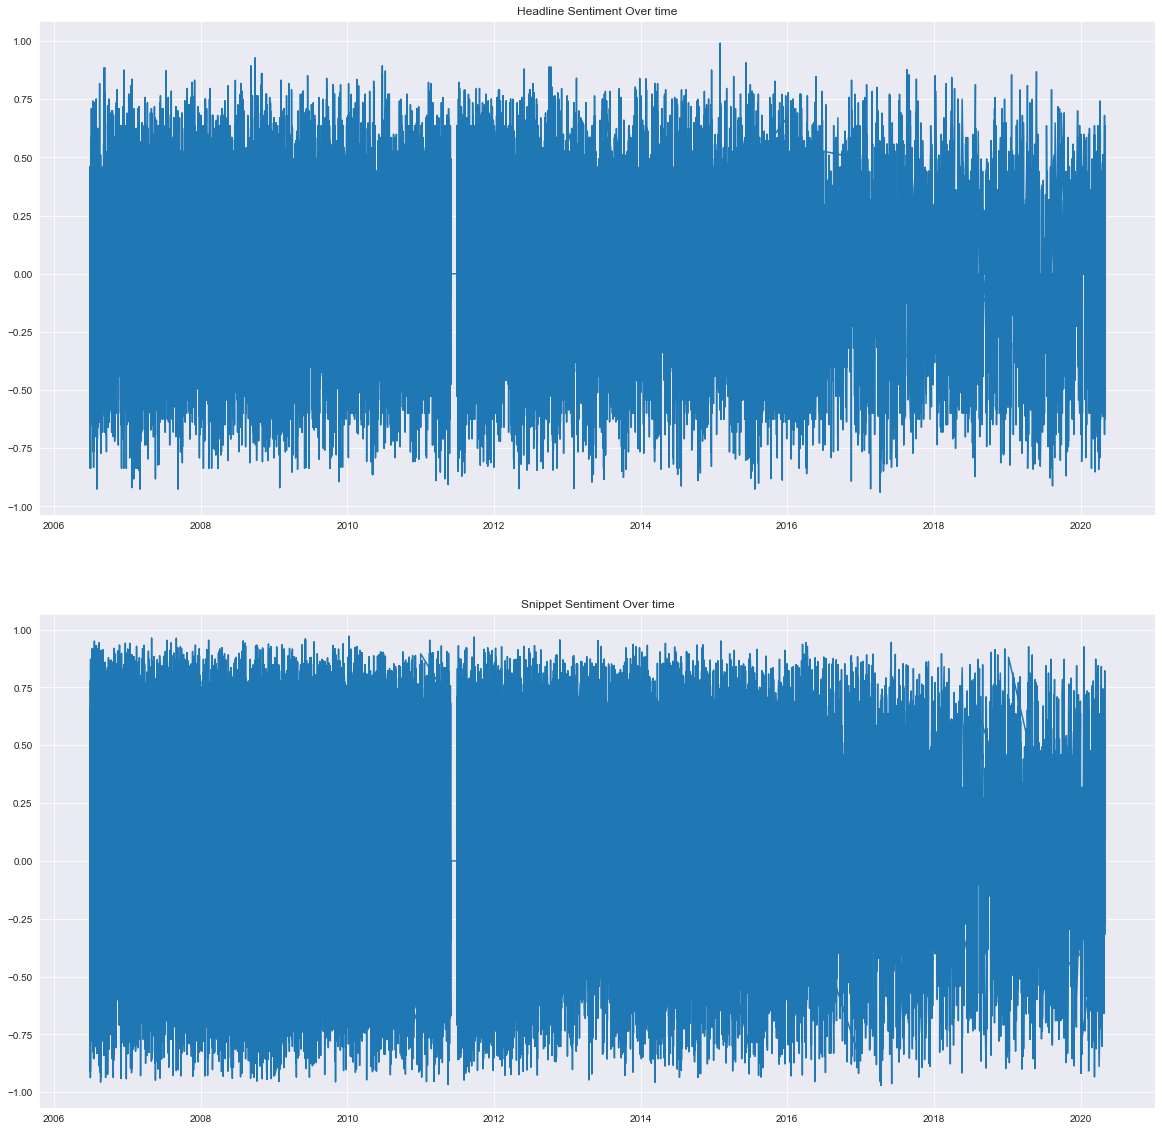

In [132]:
#Time series plots of VADER Sentiment
fig, (ax1, ax2) = plt.subplots(2,figsize=(20,20))

ax1.plot(nyt_df.index, nyt_df['Headline_VADER'])
ax1.set_title("Headline Sentiment Over time")

ax2.plot(nyt_df.index, nyt_df['Snippet_VADER'])
ax2.set_title("Snippet Sentiment Over time")

plt.show()

This data looks even noiser than the TextBlob Sentiment! Now I will convert these to weekly averages

## Weekly Sentiment

In [178]:
nyt_hl_blob = pd.DataFrame(nyt_df['Headline_Blob'])
nyt_s_blob = pd.DataFrame(nyt_df['Snippet_Blob'])
nyt_hl_vader = pd.DataFrame(nyt_df['Headline_VADER'])
nyt_s_vader = pd.DataFrame(nyt_df['Snippet_VADER'])

In [141]:
nyt_hl_blob

,Headline_Blob
Date,
2006-06-30,-0.30
2006-06-30,0.00
2006-06-30,0.80
2006-06-30,0.00
2006-06-30,0.05
...,...
2020-04-02,0.50
2020-04-21,-0.20
2020-04-21,0.00


In [144]:
nyt_s_blob

,Snippet_Blob
Date,
2006-06-30,0.232143
2006-06-30,-0.028571
2006-06-30,0.000000
2006-06-30,-0.092857
2006-06-30,0.000000
...,...
2020-04-02,0.500000
2020-04-21,0.000000
2020-04-21,0.000000


In [145]:
nyt_hl_vader

,Headline_VADER
Date,
2006-06-30,0.0000
2006-06-30,0.0000
2006-06-30,0.4588
2006-06-30,0.0000
2006-06-30,0.0000
...,...
2020-04-02,0.2500
2020-04-21,-0.1027
2020-04-21,-0.2960


In [146]:
nyt_s_vader

,Snippet_VADER
Date,
2006-06-30,0.7783
2006-06-30,0.7717
2006-06-30,0.6597
2006-06-30,0.4019
2006-06-30,0.0000
...,...
2020-04-02,-0.8885
2020-04-21,0.0000
2020-04-21,0.6597


In [179]:
#Resample to take the average weekly sentiment
nyt_hl_blob_w=nyt_hl_blob.resample('W').mean()
nyt_s_blob_w=nyt_s_blob.resample('W').mean()
nyt_hl_vader_w=nyt_hl_vader.resample('W').mean()
nyt_s_vader_w=nyt_s_vader.resample('W').mean()


In [153]:
nyt_hl_blob_w

,Headline_Blob
Date,
2006-07-02,0.026190
2006-07-09,0.016675
2006-07-16,-0.005360
2006-07-23,0.009374
2006-07-30,0.053712
...,...
2020-04-05,-0.026698
2020-04-12,-0.139169
2020-04-19,0.009387


In [154]:
nyt_s_blob_w

,Snippet_Blob
Date,
2006-07-02,0.007771
2006-07-09,0.043256
2006-07-16,0.058999
2006-07-23,0.039992
2006-07-30,0.045786
...,...
2020-04-05,0.094194
2020-04-12,0.051912
2020-04-19,0.021370


In [155]:
nyt_hl_vader_w

,Headline_VADER
Date,
2006-07-02,-0.062524
2006-07-09,-0.018492
2006-07-16,0.004790
2006-07-23,-0.020284
2006-07-30,0.105633
...,...
2020-04-05,-0.076375
2020-04-12,-0.087474
2020-04-19,0.003688


In [156]:
nyt_s_vader_w

,Snippet_VADER
Date,
2006-07-02,0.076390
2006-07-09,0.116522
2006-07-16,0.121917
2006-07-23,0.192571
2006-07-30,0.106810
...,...
2020-04-05,-0.011270
2020-04-12,0.117404
2020-04-19,-0.000462


In [180]:
#Aligning the index with the other data
nyt_hl_blob_w.index = nyt_hl_blob_w.index - DateOffset(days=3)
nyt_s_blob_w.index = nyt_s_blob_w.index - DateOffset(days=3)
nyt_hl_vader_w.index = nyt_hl_vader_w.index - DateOffset(days=3)
nyt_s_vader_w.index = nyt_s_vader_w.index - DateOffset(days=3)

In [181]:
#I'm going to check for missing data and forward fill in any missing
print(nyt_hl_blob_w.isnull().sum())
print(nyt_s_blob_w.isnull().sum())
print(nyt_hl_vader_w.isnull().sum())
print(nyt_s_vader_w.isnull().sum())


Headline_Blob    3
dtype: int64
Snippet_Blob    3
dtype: int64
Headline_VADER    3
dtype: int64
Snippet_VADER    3
dtype: int64


In [182]:
#There are only a small number missing so will simply forward fill
nyt_hl_blob_w.fillna(method='ffill',inplace=True)
nyt_s_blob_w.fillna(method='ffill',inplace=True)
nyt_hl_vader_w.fillna(method='ffill',inplace=True)
nyt_s_vader_w.fillna(method='ffill',inplace=True)

#checking that it worked
print(nyt_hl_blob_w.isnull().sum())
print(nyt_s_blob_w.isnull().sum())
print(nyt_hl_vader_w.isnull().sum())
print(nyt_s_vader_w.isnull().sum())


Headline_Blob    0
dtype: int64
Snippet_Blob    0
dtype: int64
Headline_VADER    0
dtype: int64
Snippet_VADER    0
dtype: int64


Now I will plot the weekly sentiment!

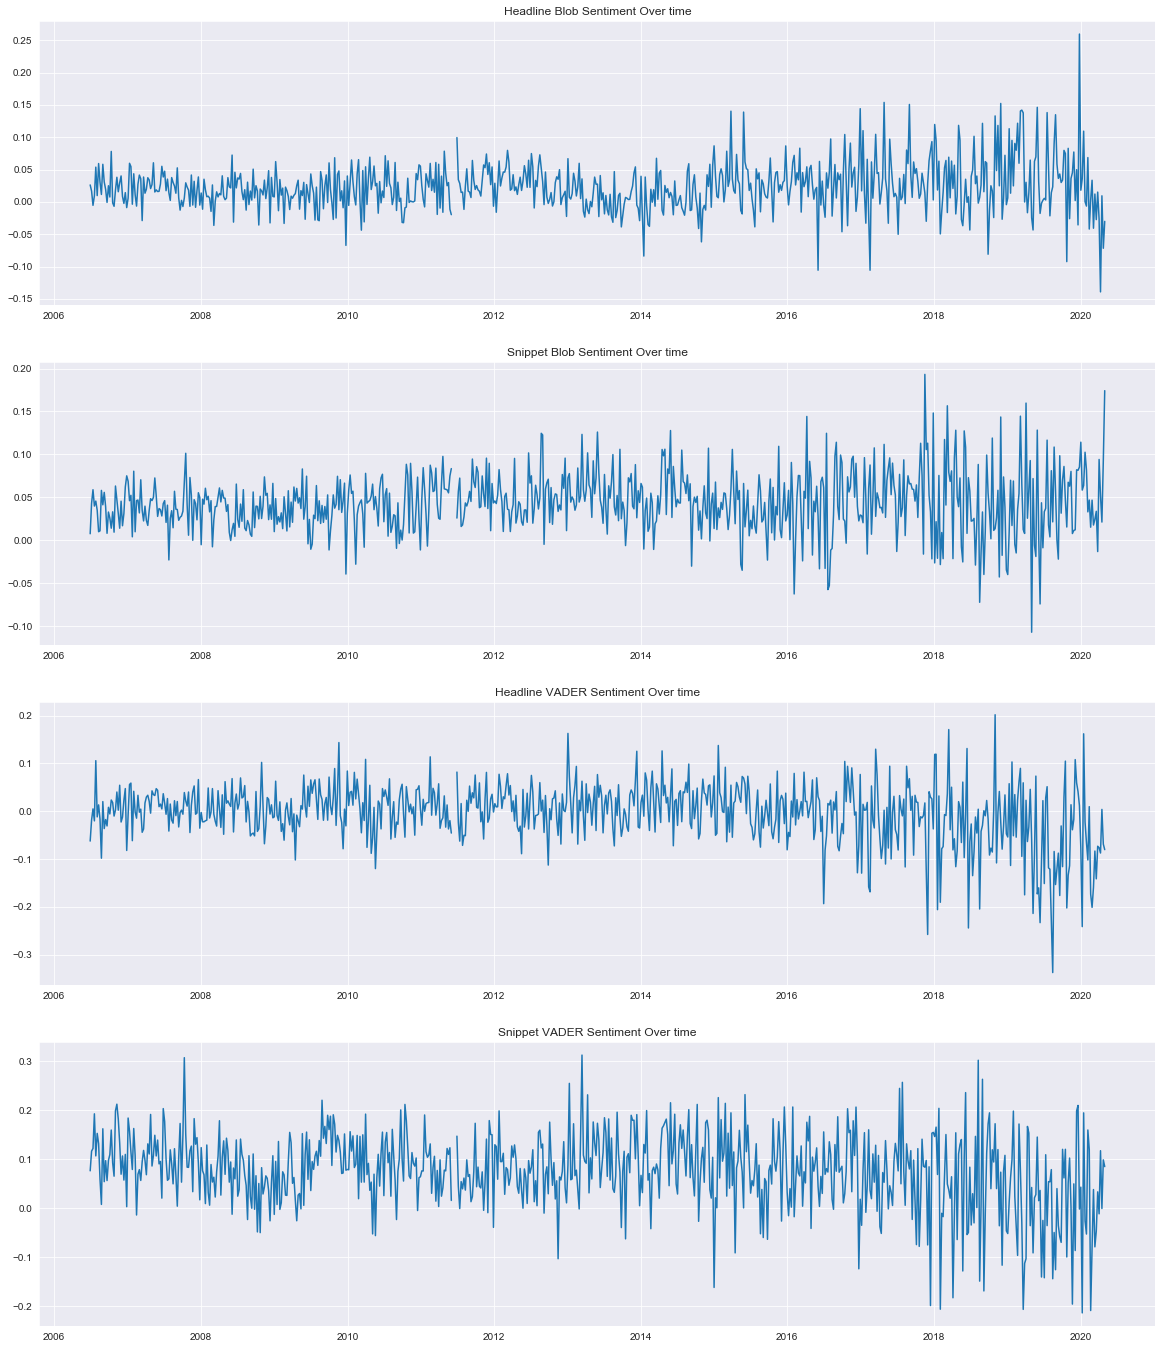

In [170]:
#Time series plots of Sentiment
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(20,24))

ax1.plot(nyt_hl_blob_w.index, nyt_hl_blob_w)
ax1.set_title("Headline Blob Sentiment Over time")

ax2.plot(nyt_s_blob_w.index, nyt_s_blob_w)
ax2.set_title("Snippet Blob Sentiment Over time")

ax3.plot(nyt_hl_vader_w.index, nyt_hl_vader_w)
ax3.set_title("Headline VADER Sentiment Over time")

ax4.plot(nyt_s_vader_w.index, nyt_s_vader_w)
ax4.set_title("Snippet VADER Sentiment Over time")

plt.show()

These all seem to have very little trend but are otherwise relatively noise. Now I'll look at the distributions of the sentiment.

In [183]:
#create one combined nyt weekly dataframe
nyt_w_df = pd.concat([nyt_hl_blob_w,nyt_s_blob_w,nyt_hl_vader_w,nyt_s_vader_w],axis=1,join='inner')


print('NY Times Sentiment Data Exploration')
print(nyt_w_df.describe().transpose())


NY Times Sentiment Data Exploration
                count      mean       std       min       25%       50%  \
Headline_Blob   723.0  0.023219  0.037912 -0.139169  0.001189  0.019878   
Snippet_Blob    723.0  0.043728  0.035481 -0.106791  0.022675  0.043396   
Headline_VADER  723.0 -0.003680  0.062408 -0.337470 -0.035423  0.004309   
Snippet_VADER   723.0  0.076285  0.078179 -0.213178  0.033659  0.078876   

                     75%       max  
Headline_Blob   0.043224  0.259500  
Snippet_Blob    0.063547  0.193163  
Headline_VADER  0.033877  0.201667  
Snippet_VADER   0.124429  0.312306  


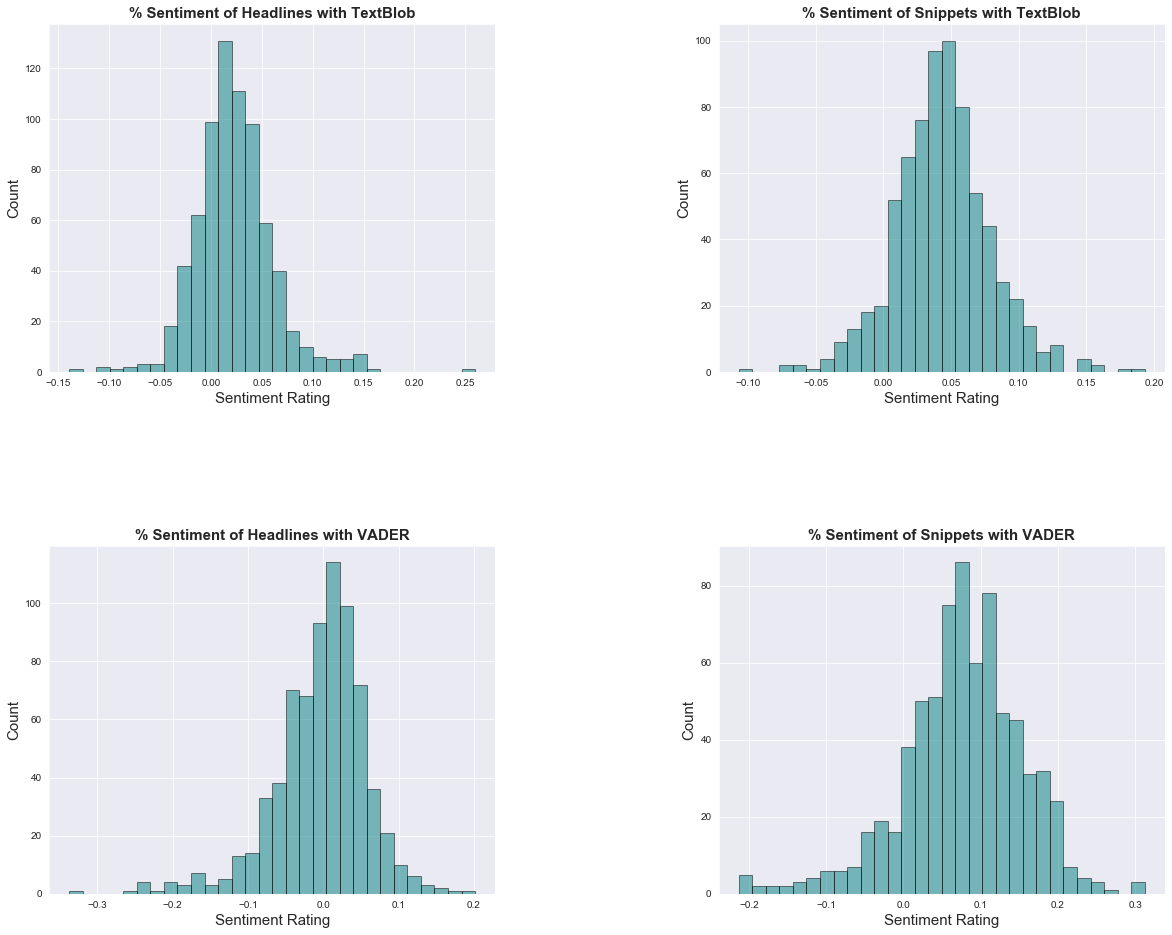

In [185]:
# Plots of the distribution of the nyt sentiment data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .5, wspace = 0.5)

ax1 = fig.add_subplot(221)
ax1.hist(nyt_w_df['Headline_Blob'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Sentiment Rating', fontsize = 15)
ax1.set_ylabel('Count',fontsize = 15)
ax1.set_title('% Sentiment of Headlines with TextBlob',fontsize = 15,fontweight='bold')

ax2 = fig.add_subplot(222)
ax2.hist(nyt_w_df['Snippet_Blob'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set_xlabel('Sentiment Rating', fontsize = 15)
ax2.set_ylabel('Count',fontsize = 15)
ax2.set_title('% Sentiment of Snippets with TextBlob',fontsize = 15,fontweight='bold')

ax3 = fig.add_subplot(223)
ax3.hist(nyt_w_df['Headline_VADER'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set_xlabel('Sentiment Rating', fontsize = 15)
ax3.set_ylabel('Count',fontsize = 15)
ax3.set_title('% Sentiment of Headlines with VADER',fontsize = 15,fontweight='bold')

ax4 = fig.add_subplot(224)
ax4.hist(nyt_w_df['Snippet_VADER'], bins = 30, alpha = .50,edgecolor= 'black',color ='teal')
ax4.set_xlabel('Sentiment Rating', fontsize = 15)
ax4.set_ylabel('Count',fontsize = 15)
ax4.set_title('% Sentiment of Snippets with VADER',fontsize = 15,fontweight='bold')

plt.show()

The sentiment data all looks roughly normal. The headlines for both TextBlob and VADER seem to be somewhat more negative than the snippets which are centered above zero.

## Exporting the new data to pickles

In [186]:
#I'm going to export the granular sentiment data and the weekly combined dataframe to pickles.

nyt_hl_blob.to_pickle('Data/nyt_hl_blob')
nyt_s_blob.to_pickle('Data/nyt_hl_blob')
nyt_hl_vader.to_pickle('Data/nyt_hl_blob')
nyt_s_vader.to_pickle('Data/nyt_hl_blob')
nyt_w_df.to_pickle('Data/nyt_w_df')